## Short Project

In [ ]:
Data:
Approximately 10M Grubhub and DoorDash sample transactions between 1/2014 - 3/2017 in the US.
    
Scope:
Use the data provided to answer the following questions:
1. What is the market share between Grubhub and Doordash in the US?
2. For members predominantly using DoorDash in January 2015, are they still predominantly using DoorDash or has their behavior changed?

In [3]:
import psycopg2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import os.path

In [4]:
# Define Excel colors

excel_theme=[(91, 155, 213), (237, 125, 49),(47, 118, 183), (61, 141, 2017)]

for i in range(len(excel_theme)):
    r, g, b=excel_theme[i]
    excel_theme[i]=(r/255., g/255., b/255.)

### DB connect

In [ ]:
cstr ='dbname=sample '+\
      'host=sample-xxxxx.redshift.amazonaws.com '+\
      'port=5439 user=xxxxx password=xxxxx'

In [ ]:
# Get data
sql='''select * from sample_grubhub_doordash'''

con=psycopg2.connect(cstr)

cur=con.cursor()
cur.execute(sql)
result=cur.fetchall()

cur.close()
con.close()

In [ ]:
cols=['company', 'date','member_id', 'amount']
df=pd.DataFrame(result, columns=cols)

print(df.shape)
df.head(3)

In [7]:
# Save to pickel
directory='/Users/Yuka/Documents/Resume/Second_Measure/project'
file='sample_grubhub_doordash_data.pkl'

#df.to_pickle(os.path.join(directory,file))
df=pd.read_pickle(os.path.join(directory,file))

In [11]:
print(df.shape)
df.head(3)

(10442410, 5)


,company,date,member_id,amount,month
0,DoorDash,2014-01-01,0ff637251252c802e6963809ceba7abc,63.0900,2014-01
1,DoorDash,2014-01-01,9cdfabab1ed111db631d0fe4017aa812,32.6700,2014-01
2,DoorDash,2014-01-01,85e094173d22407833147d648b5fa525,49.3700,2014-01


### Quick data check

In [12]:
# Potential dup records
df_dups=df[df.duplicated()].sort_values(by=['company', 'date', 'member_id'])

print(df_dups.shape)
df_dups.head(2)

(85248, 5)


,company,date,member_id,amount,month
43304,DoorDash,2014-01-06,d291f39b8773fb3c69fdc2e283a9303d,25.3400,2014-01
221760,DoorDash,2014-01-29,7cc8875b906963fbb305caed6225e124,1.7900,2014-01


In [13]:
# Example
df[(df.member_id=='6d9693ace3d64beda1d18a09424c60b4')&(df.date==dt.date(2014,1,1))]

,company,date,member_id,amount,month
13,Grubhub,2014-01-01,6d9693ace3d64beda1d18a09424c60b4,24.4700,2014-01
16,Grubhub,2014-01-01,6d9693ace3d64beda1d18a09424c60b4,24.4700,2014-01


In [14]:
# Consider them as dups and exclude them
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(10442410, 5)
(10357162, 5)


In [15]:
# Check values, min and max - OK
print('Company Name: ', df.company.unique())
print('Date min and max: ', df.date.min(), df.date.max())
print('Amount min and max: ', df.amount.min(), df.amount.max())

Company Name:  ['DoorDash' 'Grubhub']
Date min and max:  2014-01-01 2017-03-31
Amount min and max:  0.0100 8073.1201


In [16]:
# Check missing dates - None
dates = df.date.unique()
dates.sort()

np.diff(dates)[np.diff(dates)>dt.timedelta(1)]

array([], dtype=object)

### Data Observation

In [17]:
# Number of daily transactions for each company
df_test1= (df.groupby(by=['date', 'company'])
           .agg({'member_id':'count'})
           .reset_index()
           .rename(columns={'member_id':'num_transaction'})
           )

df_test1.head(3)

,date,company,num_transaction
0,2014-01-01,DoorDash,7
1,2014-01-01,Grubhub,6089
2,2014-01-02,DoorDash,8


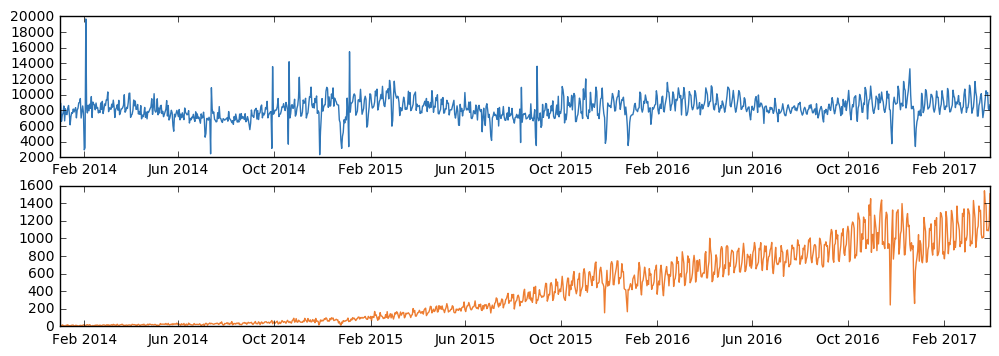

In [18]:
# Grubhub is more stable, DoorDash increased. Dips on a day after Thanksgiving and Christmas
plt.figure(figsize=(12,4))

g=df_test1[df_test1.company=='Grubhub']
d=df_test1[df_test1.company=='DoorDash']

plt.subplot(2,1,1)
plt.plot(g.date, g.num_transaction, color=excel_theme[2])
plt.subplot(2,1,2)
_= plt.plot(d.date, d.num_transaction, color=excel_theme[1])

### Q1 What is the market share between Grubhub and Doordash in the US?

In [8]:
# Add yyyy-mm column
df['month']=df.date.apply(lambda x: x.strftime('%Y')+'-'+ x.strftime('%m'))

In [9]:
# pivot df
df_pivot1=pd.pivot_table(df, values='amount'
                         , index='month'
                         , columns='company'
                         , aggfunc=sum).reset_index()

df_pivot1.head(3)

company,month,DoorDash,Grubhub
0,2014-01,14651.8000,6396639.3200
1,2014-02,16940.1500,6150914.3000
2,2014-03,21098.4200,6950767.7700


In [10]:
df_pivot1['DoorDash']=(df_pivot1['DoorDash']/1000).astype(float)
df_pivot1['Grubhub']=(df_pivot1['Grubhub']/1000).astype(float)

df_pivot1['total']=df_pivot1['DoorDash']+df_pivot1['Grubhub']

df_pivot1['DoorDash_share']=(df_pivot1['DoorDash']/df_pivot1['total']).apply(lambda x: round(x, 3))
df_pivot1['Grubhub_sahre']=(df_pivot1['Grubhub']/df_pivot1['total']).apply(lambda x: round(x, 3))

df_pivot1['DoorDash_share']=df_pivot1['DoorDash_share'].astype(float)
df_pivot1['Grubhub_sahre']=df_pivot1['Grubhub_sahre'].astype(float)

df_pivot1.head(3)

company,month,DoorDash,Grubhub,total,DoorDash_share,Grubhub_sahre
0,2014-01,14.65180,6396.63932,6411.29112,0.002,0.998
1,2014-02,16.94015,6150.91430,6167.85445,0.003,0.997
2,2014-03,21.09842,6950.76777,6971.86619,0.003,0.997


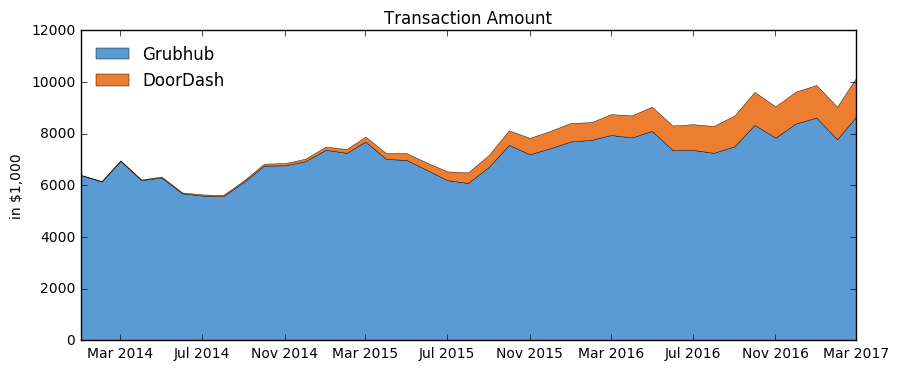

In [11]:
plt.figure(figsize=(10,4))
ax1=plt.subplot(1,1,1)

x=[dt.datetime.strptime(m, '%Y-%m') for m in df_pivot1.month]
y=[df_pivot1.Grubhub,df_pivot1.DoorDash]

plt.stackplot(x, y, labels=['Grubhub','DoorDash'], colors=excel_theme, linewidth=.3)

plt.legend(loc='upper left', frameon=False)
plt.title('Transaction Amount')
_=plt.ylabel('in $1,000')

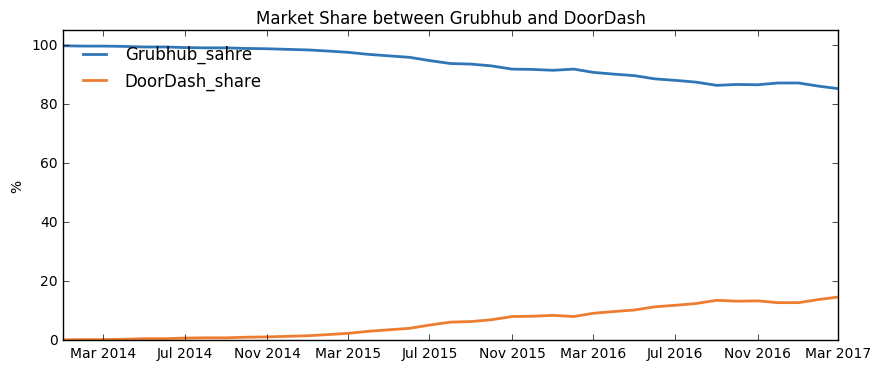

In [204]:
plt.figure(figsize=(10,4))
ax1=plt.subplot(1,1,1)

x=[dt.datetime.strptime(m, '%Y-%m') for m in df_pivot1.month]

plt.plot(x, df_pivot1.Grubhub_sahre*100, color=excel_theme[2], linewidth=2)
plt.plot(x, df_pivot1.DoorDash_share*100, color=excel_theme[1], linewidth=2)

plt.ylim(0, 105)

plt.legend(loc='upper left', frameon=False)
plt.title('Market Share between Grubhub and DoorDash')
_=plt.ylabel('%')

### Q2. For members predominantly using DoorDash in January 2015, are they still predominantly using DoorDash or has their behavior changed?

In [ ]:
# First, determine threshold for "members predominantly using DoorDash in Jan 2015" 
# Is there a good threshold to segment the 2 groups?

In [26]:
# Number of times members ordered from each company in Jan 2015
df_pivot2=pd.pivot_table(df[df.month=='2015-01']
               , values='date'
               , index='member_id'
               , columns='company'
               , aggfunc=len).reset_index()

df_pivot2[['DoorDash', 'Grubhub']]=df_pivot2.loc[:, ['DoorDash', 'Grubhub']].fillna(0)
df_pivot2['DoorDash']=df_pivot2['DoorDash'].astype(int)
df_pivot2['Grubhub']=df_pivot2['Grubhub'].astype(int)

# Find the rate of DoorDash orders
df_pivot2['num_order']=(df_pivot2['DoorDash']+df_pivot2['Grubhub']).astype(int)
df_pivot2['DoorDash_rate']=df_pivot2['DoorDash']/df_pivot2['num_order']

df_pivot2.head(3)

company,member_id,DoorDash,Grubhub,num_order,DoorDash_rate
0,000056b33001445b680248605124a4bc,0,5,5,0.0
1,00005ccf98185df1df0e812ca67b3329,0,1,1,0.0
2,00038f1cd810341fcf4f51b60bb8d957,0,2,2,0.0


In [27]:
# 72101 members ordered at least once from either company in Jan 2015
print(len(df_pivot2[df_pivot2['num_order']>=1]['member_id'].unique()))

# 1011 members ordered from DoorDash at least once in Jan 2015
print(len(df_pivot2[df_pivot2['DoorDash']>=1]['member_id'].unique()))

72101
1011


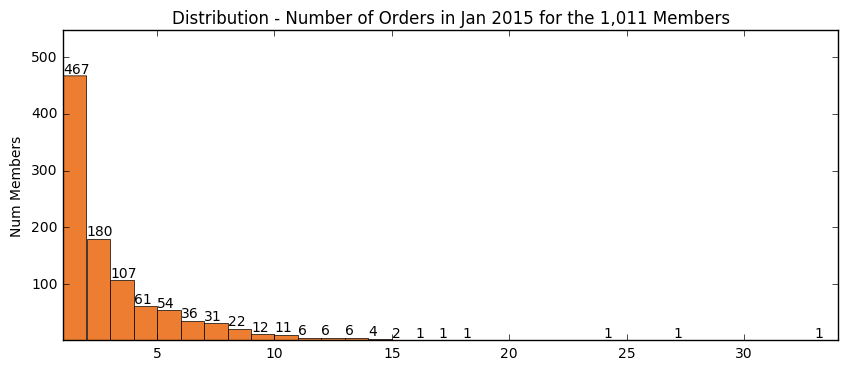

In [189]:
# Most members who ordered from DoorDash at least once in Jan 2015 ordered only once in that month
# Include members who ordered only once
plt.figure(figsize=(10,4))
ax1=plt.subplot(1,1,1)

num =df_pivot2[df_pivot2.DoorDash>=1]['num_order']
x,y,_=plt.hist(num, bins=max(num)-1, linewidth=.5, color=excel_theme[1])

for a, b in zip(range(len(x)), x):
    if b>0:
        ax1.text(a+1, b+5, int(b))
        
plt.title('Distribution - Number of Orders in Jan 2015 for the 1,011 Members')
plt.ylabel('Num Members')
plt.xlim([1,max(num)])
_=plt.ylim([1,max(x)+80])

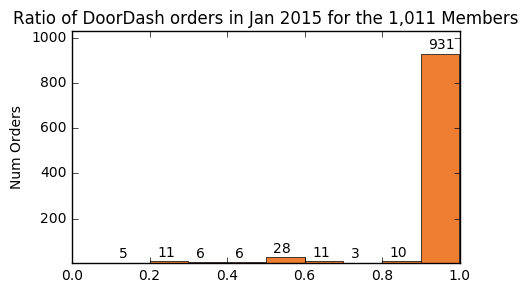

In [32]:
# There is no clear number to separate the 2 groups - Use 80% as threshold
plt.figure(figsize=(5,3))
ax1=plt.subplot(1,1,1)

r=np.arange(0,1.1,.1) # bins

x,y,_=plt.hist(df_pivot2[df_pivot2.DoorDash>=1].DoorDash_rate, bins=r, linewidth=.5, color=excel_theme[1])

for a, b in zip(x, r):
    if a>0:
        ax1.text(b+.02, a+20, int(a))
        #ax1.text(.93, x[-1]+20, int([-1]))

plt.title('Ratio of DoorDash orders in Jan 2015 for the 1,011 Members')
plt.ylabel('Num Orders')
_=plt.ylim([1,max(x)+100])

In [153]:
# Use 80% DoorDash order rate, including members who ordered only once in Jan 2015 941 members 
tr=.8

doordash_fans1=df_pivot2[df_pivot2.DoorDash_rate>=tr]['member_id'].unique().tolist()
doordash_fans2=df_pivot2[(df_pivot2.DoorDash_rate>=tr)&(df_pivot2.num_order>=3)]['member_id'].unique().tolist()
others=df_pivot2[df_pivot2.DoorDash_rate<tr]['member_id'].unique().tolist()

print(len(doordash_fans1))

941


### Q2 answer 

In [79]:
# Order stats of the Jan-2015 DoorDash fans for 2015-2017
df_pivot3=pd.pivot_table(df[(df.member_id.isin(doordash_fans1))]
                           , values='date'
                           , index=['member_id', 'month']
                           , columns='company'
                           , aggfunc=len).reset_index()

df_pivot3[['DoorDash', 'Grubhub']]=df_pivot3.loc[:, ['DoorDash', 'Grubhub']].fillna(0)
df_pivot3['DoorDash']=df_pivot3['DoorDash'].astype(int)
df_pivot3['Grubhub']=df_pivot3['Grubhub'].astype(int)

# Find the rate of DoorDash orders
df_pivot3['num_order']=(df_pivot3['DoorDash']+df_pivot3['Grubhub']).astype(int)
df_pivot3['DoorDash_rate']=df_pivot3['DoorDash']/df_pivot3['num_order']

df_pivot3.head(3)

company,member_id,month,DoorDash,Grubhub,num_order,DoorDash_rate
0,00605841ff8de0ebfaab4814a2730bc0,2015-01,1,0,1,1.0
1,00605841ff8de0ebfaab4814a2730bc0,2015-03,1,0,1,1.0
2,00605841ff8de0ebfaab4814a2730bc0,2015-04,2,0,2,1.0


In [80]:
# Their DoorDash order rate for 2015-2017

# Number of DoorDash fans (Base is th 941 members)
t1=(df_pivot3[(df_pivot3.DoorDash_rate>=tr)&(df_pivot3.month>='2015-01')]
    .groupby(by=['month'])['member_id']
    .count()
    .reset_index()
    )

# Number members who ordered from either company (Base is th 941 members)
base=(df_pivot3[(df_pivot3.month>='2015-01')]
    .groupby(by=['month'])['member_id']
    .count()
    .reset_index()
    )

merged=pd.merge(t1, base, how='inner', on='month')
merged.columns=['month', 'Num_DoorDash_fans', 'Num']
merged['rate']=merged['Num_DoorDash_fans']/merged['Num']

merged.head()

,month,Num_DoorDash_fans,Num,rate
0,2015-01,941,941,1.000000
1,2015-02,566,588,0.962585
2,2015-03,542,571,0.949212
3,2015-04,519,548,0.947080
4,2015-05,519,551,0.941924


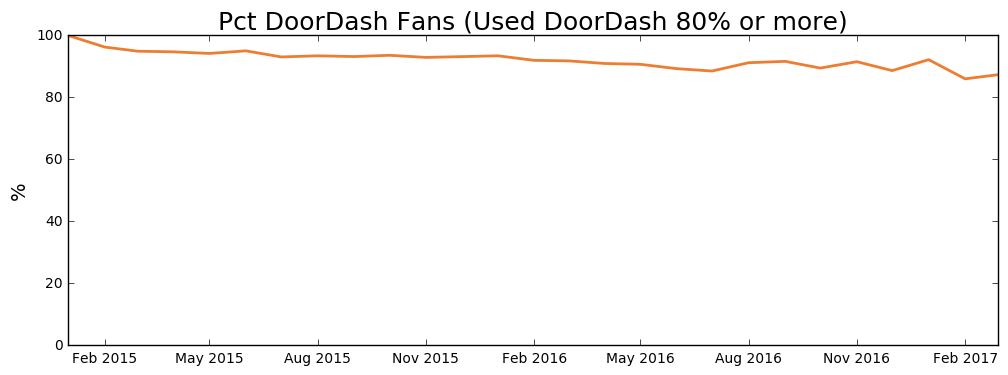

In [81]:
plt.figure(figsize=(12,4))

list_month=[dt.datetime.strptime(m, '%Y-%m') for m in merged.month]

plt.plot(list_month, merged.rate*100, color=excel_theme[1], linewidth=2)

plt.title('Pct DoorDash Fans (Used DoorDash 80% or more)', fontsize='18')
plt.ylabel('%', fontsize='14')
_=plt.ylim(0, 100)

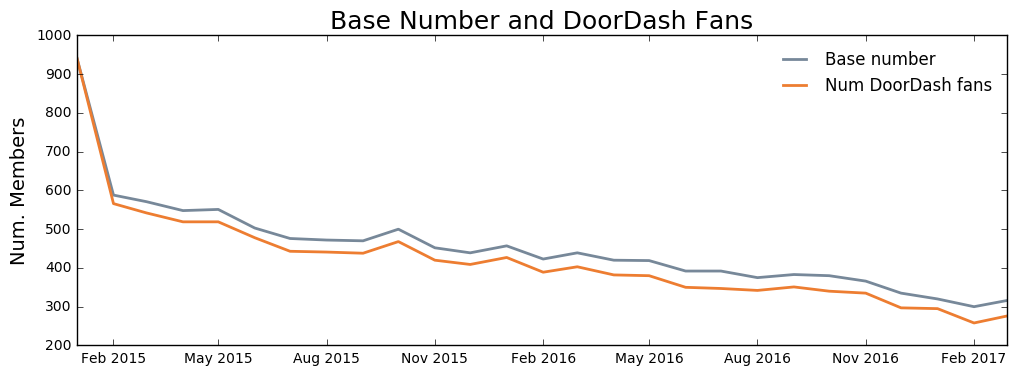

In [82]:
plt.figure(figsize=(12,4))
ax1=plt.subplot(1,1,1)

x=[dt.datetime.strptime(m, '%Y-%m') for m in merged.month]
y=[merged.Num_DoorDash_fans, merged.Num]

plt.plot(x, merged.Num, color='lightslategray', linewidth=2, label='Base number')
plt.plot(x, merged.Num_DoorDash_fans, color=excel_theme[1], linewidth=2, label='Num DoorDash fans')

plt.legend(loc='upper right', frameon=False)
plt.title('Base Number and DoorDash Fans', fontsize=18)
_=plt.ylabel('Num. Members', fontsize='14')

In [90]:
#merged

In [2]:
# # How many times did the 941 DoorDash fans order between 1/2014 - 3/2017?
# t=pd.DataFrame(df_pivot3.groupby('member_id')['num_order'].sum())

# plt.figure(figsize=(12,4), linewidth=.5)

# _=plt.hist(np.clip(t.num_order,0,200),bins=200)